In [ ]:
#
# Script that reads thermodynamics calculations and analyses them
# João Inácio, July 4th, 2021
#

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# System and simulation information

dim = "2D"
lattice = "SS"
NN = 4

L_vals = np.array([4, 8, 16])


In [3]:
# Read files

temperatures = np.loadtxt("./thermodynamic_variables/SS/L4/temperatures.txt")
energies = list()
magnetizations = list()

mod_M = np.zeros((len(L_vals), len(temperatures)))
M_minF = np.zeros((len(L_vals), len(temperatures)))

C_mean = np.zeros((len(L_vals), len(temperatures)))
C = np.zeros((len(L_vals), len(temperatures)-2))

M2 = np.zeros((len(L_vals), len(temperatures)))
M4 = np.zeros((len(L_vals), len(temperatures)))

for idx_L, L in enumerate(L_vals):
    energies.append(np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/energies.txt"))
    magnetizations.append(np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/magnetizations.txt"))
    
    mod_M[idx_L, :] = np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/mod_M.txt")
    M_minF[idx_L, :] = np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/MminF.txt")
    
    C_mean[idx_L, :] = np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/C_mean.txt")
    C[idx_L, :] = np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/C.txt")
    
    M2[idx_L, :] = np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/M2.txt")
    M4[idx_L, :] = np.loadtxt("./thermodynamic_variables/SS/L" + str(L) + "/M4.txt")


In [4]:
# Find exact M and C

T_vals = np.arange(0.1, 4.54, 0.01)
F_exact = np.zeros(len(T_vals))
M_exact = np.zeros(len(T_vals))
C_exact = np.zeros(len(T_vals))
Tc_exact = 2.269

for i,T in enumerate(T_vals):
    if T < Tc_exact:
        M_exact[i] = (1 - np.sinh(2 / T)**(-4))**(1/8)


x = np.arange(0, np.pi, 0.01)
for i,T in enumerate(T_vals):
    k = 2 * np.sinh(2 / T) / (np.cosh(2 / T)**2)
    integral = np.trapz(np.log(1 + np.sqrt(1 - (k * np.cos(x))**2)), x)
    
    F_exact[i] = - np.log(2) / 2 - np.log(np.cosh(2 / T)) - 1 / (2 * np.pi) * integral
    F_exact[i] *= T

for i in range(1 , len(T_vals) - 1):
    C_exact[i] = - T_vals[i] * (F_exact[i - 1] - 2 * F_exact[i] + F_exact[i + 1]) / (0.01**2)
    
    
#plt.figure(1)
#plt.plot(T_vals, M_exact)

#plt.figure(2)
#plt.plot(T_vals, F_exact)

#plt.figure(3)
#plt.plot(T_vals, C_exact)

#plt.show()
        

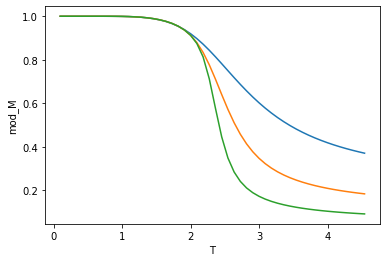

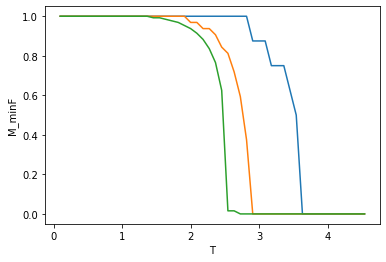

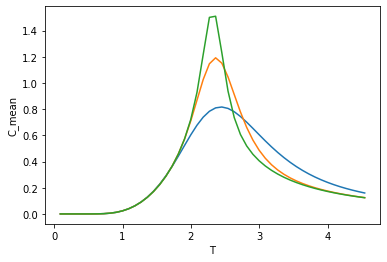

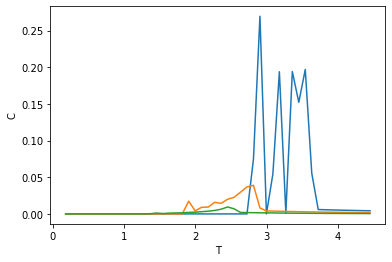

In [5]:
# Plot thermodynamics

for idx_L in range(len(L_vals)):
    plt.figure(1)
    plt.plot(temperatures, mod_M[idx_L, :])
    plt.xlabel("T")
    plt.ylabel("mod_M") 
    
    plt.figure(2)
    plt.plot(temperatures, M_minF[idx_L, :])
    plt.xlabel("T")
    plt.ylabel("M_minF") 

    plt.figure(3)
    plt.plot(temperatures, C_mean[idx_L, :])
    plt.xlabel("T")
    plt.ylabel("C_mean")
    
    plt.figure(4)
    plt.plot(temperatures[1:-1], C[idx_L, :])
    plt.xlabel("T")
    plt.ylabel("C")
    
plt.show()


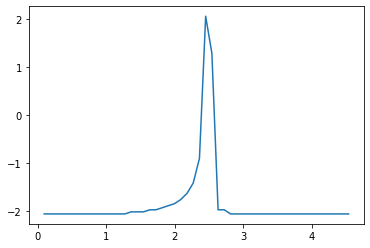

In [6]:
# Find Tc from magnetization

h = np.abs(temperatures[1] - temperatures[2])
M_minF_fd = np.zeros((len(L_vals), len(temperatures)))
mod_M_fd = np.zeros((len(L_vals), len(temperatures)))

for i in range(1, len(temperatures) - 1):
    M_minF_fd[:, i] = (M_minF[:, i + 1] - M_minF[:, i - 1]) / (2 * h)
    mod_M_fd[:, i] = (mod_M[:, i + 1] - mod_M[:, i - 1]) / (2 * h)

idx_Tc_M_minF = np.zeros(len(L_vals), dtype=int)
Tc_M_minF = np.zeros(len(L_vals))
idx_Tc_mod_M = np.zeros(len(L_vals), dtype=int)
Tc_mod_M = np.zeros(len(L_vals))

for idx_L in range(len(L_vals)):
    idx_Tc_M_minF[idx_L] = np.where(M_minF_fd[idx_L, :] == np.min(M_minF_fd[idx_L, :]))[0][0]
    Tc_M_minF[idx_L] = temperatures[idx_Tc_M_minF[idx_L]]
    idx_Tc_mod_M[idx_L] = np.where(mod_M_fd[idx_L, :] == np.min(mod_M_fd[idx_L, :]))[0][0]
    Tc_mod_M[idx_L] = temperatures[idx_Tc_mod_M[idx_L]]

new_mod_M_fd = np.zeros((len(L_vals), len(temperatures)))
delta_Tc_mod_M = np.zeros((len(L_vals), 2))

for idx_L in range(len(L_vals)):    
    new_mod_M_fd[idx_L, :] = np.abs(mod_M_fd[idx_L, :]) - np.abs(mod_M_fd[idx_L, idx_Tc_mod_M[idx_L]]) / 2
        
    for i in range(1, len(temperatures)-2):
        if new_mod_M_fd[idx_L, i] < 0 and new_mod_M_fd[idx_L, i+1] > 0:
            delta_Tc_mod_M[idx_L, 0] = np.interp(0, new_mod_M_fd[idx_L, i:i+1], temperatures[i:i+1])
            delta_Tc_mod_M[idx_L, 0] = np.abs(delta_Tc_mod_M[idx_L, 0] - Tc_mod_M[idx_L])
        elif new_mod_M_fd[idx_L, i] > 0 and new_mod_M_fd[idx_L, i+1] < 0:
            delta_Tc_mod_M[idx_L, 1] = np.interp(0, new_mod_M_fd[idx_L, i:i+1], temperatures[i:i+1])
            delta_Tc_mod_M[idx_L, 1] = np.abs(delta_Tc_mod_M[idx_L, 1] - Tc_mod_M[idx_L])

new_M_minF_fd = np.zeros((len(L_vals), len(temperatures)))
delta_Tc_minF = np.zeros((len(L_vals), 2))

for idx_L in range(len(L_vals)):    
    new_M_minF_fd[idx_L, :] = np.abs(M_minF_fd[idx_L, :]) - np.abs(M_minF_fd[idx_L, idx_Tc_M_minF[idx_L]]) / 2
        
    for i in range(1, len(temperatures)-2):
        if new_M_minF_fd[idx_L, i] < 0 and new_M_minF_fd[idx_L, i+1] > 0:
            delta_Tc_minF[idx_L, 0] = np.interp(0, new_M_minF_fd[idx_L, i:i+1], temperatures[i:i+1])
            delta_Tc_minF[idx_L, 0] = np.abs(delta_Tc_minF[idx_L, 0] - Tc_M_minF[idx_L])
        elif new_M_minF_fd[idx_L, i] > 0 and new_M_minF_fd[idx_L, i+1] < 0:
            delta_Tc_minF[idx_L, 1] = np.interp(0, new_M_minF_fd[idx_L, i:i+1], temperatures[i:i+1])
            delta_Tc_minF[idx_L, 1] = np.abs(delta_Tc_minF[idx_L, 1] - Tc_M_minF[idx_L])
plt.plot(temperatures, new_M_minF_fd[2, :])
plt.show()

In [7]:
# Fit Tc(inf)

a = np.polyfit(1/L_vals, Tc_M_minF, 1)
print(a)

a = np.polyfit(1/L_vals, Tc_mod_M, 1)
print(a)


[5.8112 2.0884]
[0.93394286 2.3154    ]


In [8]:
# Binder Comulant

U = np.zeros((len(L_vals), len(temperatures)))

for idx_L in range(len(L_vals)):
    U[idx_L, :] = 1 - M4[idx_L, :] / (3 * M2[idx_L, :]**2)
    
U1 = U[0, :] - U[1, :]
U2 = U[0, :] - U[2, :]
U3 = U[1, :] - U[2, :]

Tc_binder = np.zeros(3)

for i in range(5, len(temperatures) - 5):
    if U1[i] < 0 and U1[i + 1] > 0:
        Tc_binder[0] = np.interp(0, U1[i:i+1], temperatures[i:i+1])

    if U2[i] < 0 and U2[i + 1] > 0:
        Tc_binder[1] = np.interp(0, U2[i:i+1], temperatures[i:i+1])
        
    if U3[i] < 0 and U3[i + 1] > 0:
        Tc_binder[2] = np.interp(0, U3[i:i+1], temperatures[i:i+1])
print(Tc_binder)
#plt.figure(1)
#for idx_L in range(len(L_vals)):
#    plt.plot(temperatures, U[idx_L, :], '-o')
#plt.show()


[2.1792 2.1792 2.1792]


In [11]:
# Write to file

with open("M_C_exact.txt", 'w') as file:
    for i in range(len(T_vals)):
        file.write(f"{T_vals[i]} {M_exact[i]} {C_exact[i]}\n")

for idx_L in range(len(L_vals)):
    with open("M_C_L" + str(L_vals[idx_L]) + ".txt", 'w') as file:
        for i in range(len(temperatures)):
            if i == 0 or i == len(temperatures) - 1:
                file.write(f"{temperatures[i]} {M_minF[idx_L, i]} {0} {mod_M[idx_L, i]} {C_mean[idx_L, i]}\n")
            else:
                file.write(f"{temperatures[i]} {M_minF[idx_L, i]} {C[idx_L, i-1]} {mod_M[idx_L, i]} {C_mean[idx_L, i]}\n")
            
with open("Tc_M_minF.txt", 'w') as file:
    for idx_L in range(len(L_vals)):
        file.write(f"{Tc_M_minF[idx_L]} {delta_Tc_minF[idx_L, 0]} {delta_Tc_minF[idx_L, 1]}\n")
            
with open("Tc_M_mean.txt", 'w') as file:
    for idx_L in range(len(L_vals)):
        file.write(f"{Tc_mod_M[idx_L]} {delta_Tc_mod_M[idx_L, 0]} {delta_Tc_mod_M[idx_L, 1]}\n")

for idx_L in range(len(L_vals)):
    with open("binder_cumulant_L" + str(L_vals[idx_L]) + ".txt", 'w') as file:
        for i in range(len(temperatures)):
            file.write(f"{temperatures[i]} {U[idx_L, i]}\n")
                        